In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import math
import copy
import folium

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, KFold, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# #Amsterdam
# amsterdam_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/amsterdam_weekdays.csv')
# amsterdam_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/amsterdam_weekends.csv')

# #Athens
# athens_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/athens_weekdays.csv')
# athens_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/athens_weekends.csv')

# #Barcelona
# barcelona_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/barcelona_weekdays.csv')
# barcelona_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/barcelona_weekends.csv')

# #Berlin
# berlin_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/berlin_weekdays.csv')
# berlin_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/berlin_weekends.csv')

# #Budapest
# budapest_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/budapest_weekdays.csv')
# budapest_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/budapest_weekends.csv')

# #Lisbon
# lisbon_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/lisbon_weekdays.csv')
# lisbon_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/lisbon_weekends.csv')

# #London
# london_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/london_weekdays.csv')
# london_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/london_weekends.csv')

# #Paris
# paris_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/paris_weekdays.csv')
# paris_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/paris_weekends.csv')

# #Rome
# rome_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/rome_weekdays.csv')
# rome_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/rome_weekends.csv')

# #Vienna
# vienna_weekdays = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/vienna_weekdays.csv')
# vienna_weekend = pd.read_csv('/kaggle/input/airbnb-price-determinants-in-europe/vienna_weekends.csv')

In [3]:
# datasets = [
#     (amsterdam_weekdays, "Amsterdam", True),
#     (amsterdam_weekend, "Amsterdam", False),
#     (athens_weekdays, "Athens", True),
#     (athens_weekend, "Athens", False),
#     (barcelona_weekdays, "Barcelona", True),
#     (barcelona_weekend, "Barcelona", False),
#     (berlin_weekdays, "Berlin", True),
#     (berlin_weekend, "Berlin", False),
#     (budapest_weekdays, "Budapest", True),
#     (budapest_weekend, "Budapest", False),
#     (lisbon_weekdays, "Lisbon", True),
#     (lisbon_weekend, "Lisbon", False),
#     (london_weekdays, "London", True),
#     (london_weekend, "London", False),
#     (paris_weekdays, "Paris", True),
#     (paris_weekend, "Paris", False),
#     (rome_weekdays, "Rome", True),
#     (rome_weekend, "Rome", False),
#     (vienna_weekdays, "Vienna", True),
#     (vienna_weekend, "Vienna", False)
# ]

# df = pd.DataFrame()

# for data, city, is_weekday in datasets:
#     data['city'] = city
#     data['weekday'] = is_weekday
#     df = pd.concat([df, data], ignore_index=True)

# df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)

# print(df.head())
# print(df.shape)

In [4]:
path = "/kaggle/input/airbnb-price-determinants-in-europe/barcelona_weekdays.csv"
df = pd.read_csv(path, index_col=0)
df.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
0,474.317499,Entire home/apt,False,False,4.0,False,0,1,10.0,91.0,1,1.111996,0.630491,526.469420,17.942927,915.587083,20.154890,2.17556,41.39624
1,169.897829,Private room,False,True,2.0,True,1,0,10.0,88.0,1,1.751839,0.124017,320.127526,10.910462,794.277350,17.484489,2.14906,41.38714
2,161.984779,Private room,False,True,4.0,False,0,1,9.0,88.0,1,1.670493,0.080322,344.073936,11.726595,840.673617,18.505814,2.15357,41.37859
3,367.956804,Entire home/apt,False,False,3.0,False,0,1,10.0,91.0,1,1.475847,0.093107,400.057449,13.634603,946.589884,20.837357,2.16839,41.37390
4,196.895292,Private room,False,True,3.0,False,1,0,9.0,91.0,1,1.855452,0.272486,346.042245,11.793678,792.296039,17.440874,2.15238,41.37699


# Data Exploration Process

## Pre-Processing

### Add data shuffle

In [5]:
np.random.seed(144)
df = df.sample(frac=1).reset_index(drop=True)

### DEALING WITH MISSING VALUES

In [6]:
df.describe()

,realSum,person_capacity,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
count,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000,1555.000000
mean,288.391667,2.756270,0.376849,0.350482,9.285531,90.929260,1.216720,2.117302,0.434875,464.371805,15.826540,877.664048,19.320087,2.168975,41.393308
std,321.180435,1.276615,0.484752,0.477275,1.007445,8.695707,0.569475,1.351517,0.275846,268.318982,9.144744,461.294504,10.154512,0.019657,0.015947
min,69.588289,2.000000,0.000000,0.000000,2.000000,20.000000,0.000000,0.119903,0.013004,93.820461,3.197553,159.835498,3.518471,2.105190,41.349540
25%,161.984779,2.000000,0.000000,0.000000,9.000000,88.000000,1.000000,1.090570,0.252128,282.772255,9.637335,494.391320,10.883075,2.156000,41.381215
50%,208.532129,2.000000,0.000000,0.000000,10.000000,93.000000,1.000000,1.751839,0.370507,389.198464,13.264511,801.812049,17.650351,2.170710,41.390360
75%,335.373659,3.000000,1.000000,1.000000,10.000000,97.000000,1.000000,2.949202,0.554220,591.594276,20.162487,1211.256634,26.663486,2.179375,41.404000
max,6943.700980,6.000000,1.000000,1.000000,10.000000,100.000000,6.000000,8.443957,2.402779,2934.133441,100.000000,4542.754150,100.000000,2.225520,41.463080


In [7]:
df.shape

(1555, 19)

In [8]:
df = df.dropna()
df.shape

(1555, 19)

### Remove OUTLIERS

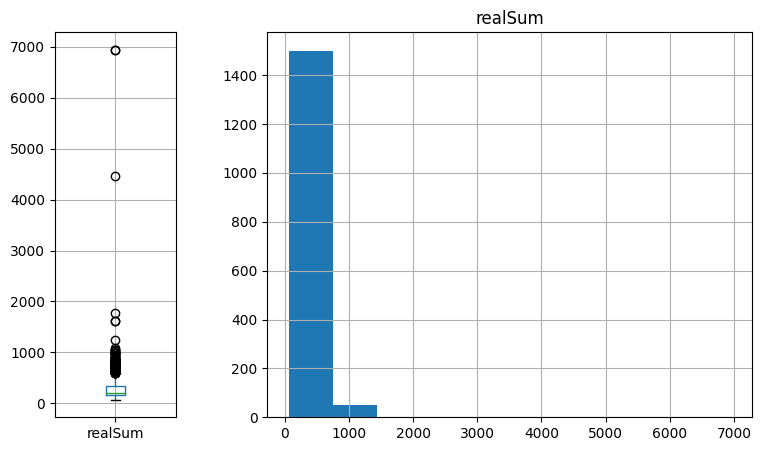

In [9]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
df.boxplot(column='realSum',ax=axes[0]);
df.hist(column='realSum', ax=axes[1]);

In [10]:
Q1 = df['realSum'].quantile(0.25)
Q3 = df['realSum'].quantile(0.75)
IQR = Q3 - Q1

In [11]:
small_outliers = df['realSum'] < (Q1 - 1.5 * IQR)
big_outliers = df['realSum'] > (Q3 + 1.5 * IQR)

sum(small_outliers), sum(big_outliers)

(0, 117)

In [12]:
df['realSum'][small_outliers | big_outliers].head()

0      780.133591
37    1041.729700
39     729.164242
43     601.624503
79     790.374008
Name: realSum, dtype: float64

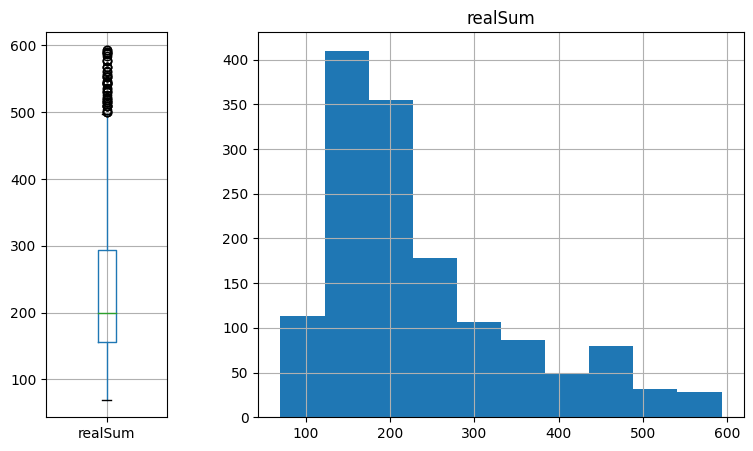

In [13]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,5))
df[~(small_outliers | big_outliers)].boxplot(column='realSum',ax=axes[0]);
df[~(small_outliers | big_outliers)].hist(column='realSum', ax=axes[1]);

In [14]:
df = df[~(small_outliers | big_outliers)]
df.shape

(1438, 19)

In [15]:
df.dtypes

realSum                       float64
room_type                      object
room_shared                      bool
room_private                     bool
person_capacity               float64
host_is_superhost                bool
multi                           int64
biz                             int64
cleanliness_rating            float64
guest_satisfaction_overall    float64
bedrooms                        int64
dist                          float64
metro_dist                    float64
attr_index                    float64
attr_index_norm               float64
rest_index                    float64
rest_index_norm               float64
lng                           float64
lat                           float64
dtype: object

## Data Clustering

In [16]:
df_copy = df.copy()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

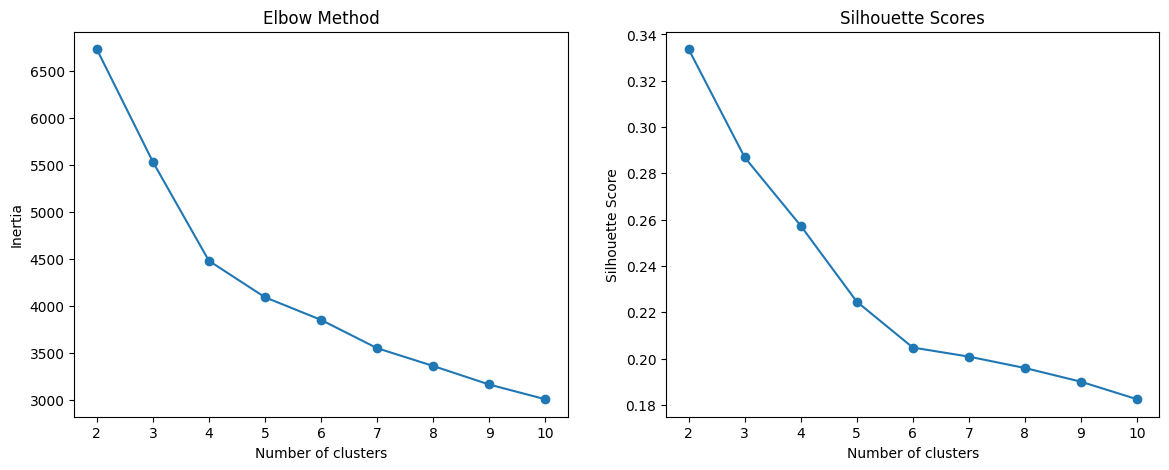

In [17]:
# Selecting the relevant features
features = df_copy[['realSum', 'person_capacity', 'cleanliness_rating', 'guest_satisfaction_overall', 'lng', 'lat']]

# Handling missing values
imputer = SimpleImputer(strategy='mean')
features_imputed = imputer.fit_transform(features)

# Standardizing the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)

# Determining the optimal number of clusters using the Elbow method and silhouette score
inertia = []
silhouette_scores = []
K = range(2, 11)  # Testing from 2 to 10 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features_scaled, kmeans.labels_))

# Plotting the Elbow curve and Silhouette scores
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot(K, inertia, marker='o')
ax[0].set_xlabel('Number of clusters')
ax[0].set_ylabel('Inertia')
ax[0].set_title('Elbow Method')

ax[1].plot(K, silhouette_scores, marker='o')
ax[1].set_xlabel('Number of clusters')
ax[1].set_ylabel('Silhouette Score')
ax[1].set_title('Silhouette Scores')

plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


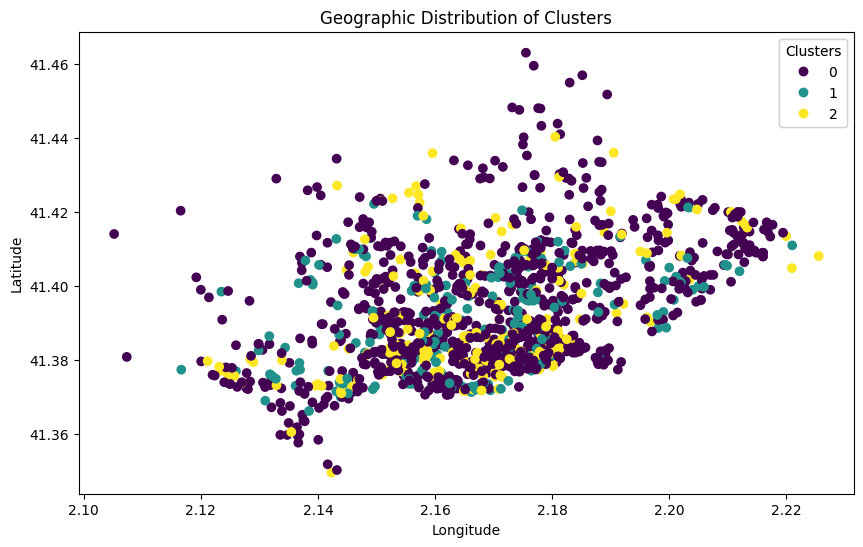

In [18]:
# Attempting to cluster with a chosen number of clusters (4)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

# Adding cluster labels to the data
df_copy['Cluster'] = clusters

# Visualizing the clusters using a scatter plot (geographic coordinates)
fig, ax = plt.subplots(figsize=(10, 6))
scatter = ax.scatter(df_copy['lng'], df_copy['lat'], c=df_copy['Cluster'], cmap='viridis', label=df_copy['Cluster'])
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Geographic Distribution of Clusters')
plt.show()

In [19]:
# Running K-means clustering again with a chosen number of clusters (4)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(features_scaled)

# Adding cluster labels to the data
df_copy['Cluster'] = clusters

# Analyzing the characteristics of each cluster
cluster_characteristics = df_copy.groupby('Cluster').agg({
    'realSum': ['mean', 'std'],
    'person_capacity': ['mean', 'std'],
    'cleanliness_rating': ['mean', 'std'],
    'guest_satisfaction_overall': ['mean', 'std'],
    'lng': ['mean'],
    'lat': ['mean']
}).round(2)

cluster_characteristics

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


realSum        person_capacity       cleanliness_rating        \
           mean    std            mean   std               mean   std   
Cluster                                                                 
0        201.91  69.51            2.13  0.40               9.63  0.50   
1        432.98  85.77            4.58  1.03               9.50  0.71   
2        190.91  80.09            2.34  0.74               7.84  1.23   

        guest_satisfaction_overall         lng    lat  
                              mean   std  mean   mean  
Cluster                                                
0                            94.15  4.47  2.17  41.39  
1                            90.75  7.48  2.17  41.39  
2                            79.51  9.99  2.17  41.39

## Data Visualization

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


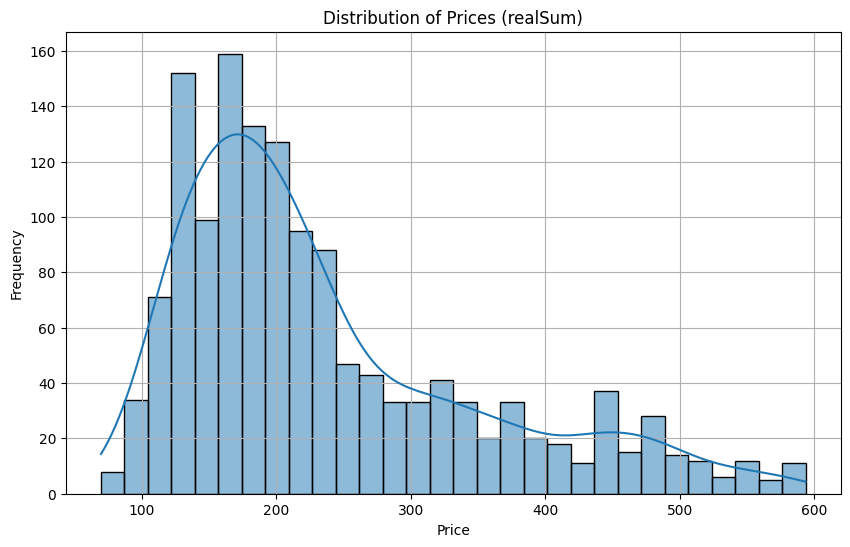

<function matplotlib.pyplot.show(close=None, block=None)>

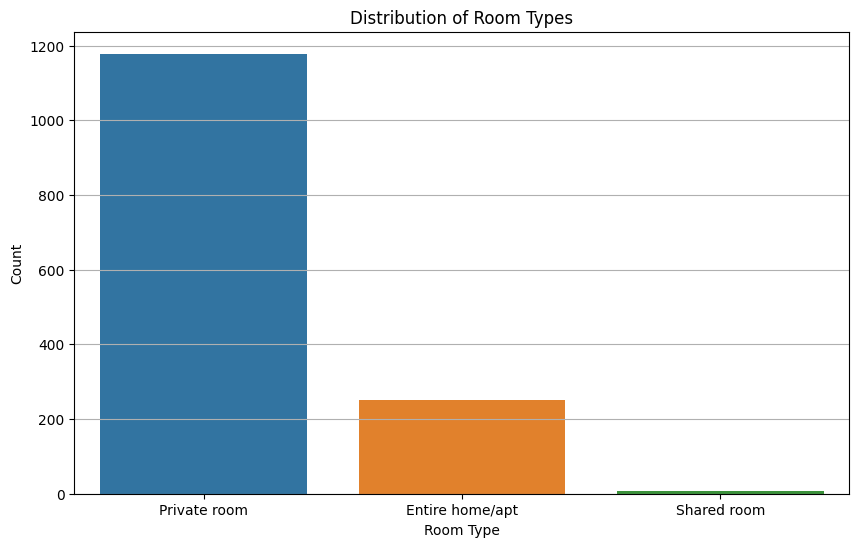

In [20]:
# 1. Summary Statistics for 'realSum'
plt.figure(figsize=(10, 6))
sns.histplot(df['realSum'], bins=30, kde=True)
plt.title('Distribution of Prices (realSum)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 2. Distribution of Room Types
plt.figure(figsize=(10, 6))
sns.countplot(x='room_type', data=df)
plt.title('Distribution of Room Types')
plt.xlabel('Room Type')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show

In [21]:
# # Count occurrences of each city
# city_counts = df['city'].value_counts()

# # Plotting
# plt.figure(figsize=(10, 8))
# plt.pie(city_counts, labels=city_counts.index, autopct='%1.1f%%', startangle=140)
# plt.title('Distribution of Cities')
# plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# plt.show()

In [22]:
# sns.pairplot(data=df[["realSum", "room_type", "person_capacity", "bedrooms", "rest_index", "city"]], hue='realSum');

In [23]:
df.dtypes

realSum                       float64
room_type                      object
room_shared                      bool
room_private                     bool
person_capacity               float64
host_is_superhost                bool
multi                           int64
biz                             int64
cleanliness_rating            float64
guest_satisfaction_overall    float64
bedrooms                        int64
dist                          float64
metro_dist                    float64
attr_index                    float64
attr_index_norm               float64
rest_index                    float64
rest_index_norm               float64
lng                           float64
lat                           float64
dtype: object

In [24]:
capitals_lat_lng = {
    'Amsterdam': [52.377956, 4.897070],
    'Athens': [37.983810, 23.727539],
    'Barcelona': [41.390205, 2.154007],
    'Berlin': [52.520008, 13.404954],
    'Budapest': [47.497913, 19.040236],
    'Lisbon': [38.736946, -9.142685],
    'London': [51.509865, -0.118092],
    'Paris': [48.864716, 2.349014],
    'Rome': [41.902782, 12.496366],
    'Vienna': [48.210033, 16.363449]
}

map = folium.Map(location=capitals_lat_lng['Budapest'], zoom_start=4.2)

for city, coords in capitals_lat_lng.items():
    folium.Marker(location=coords, popup=city).add_to(map)

map

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


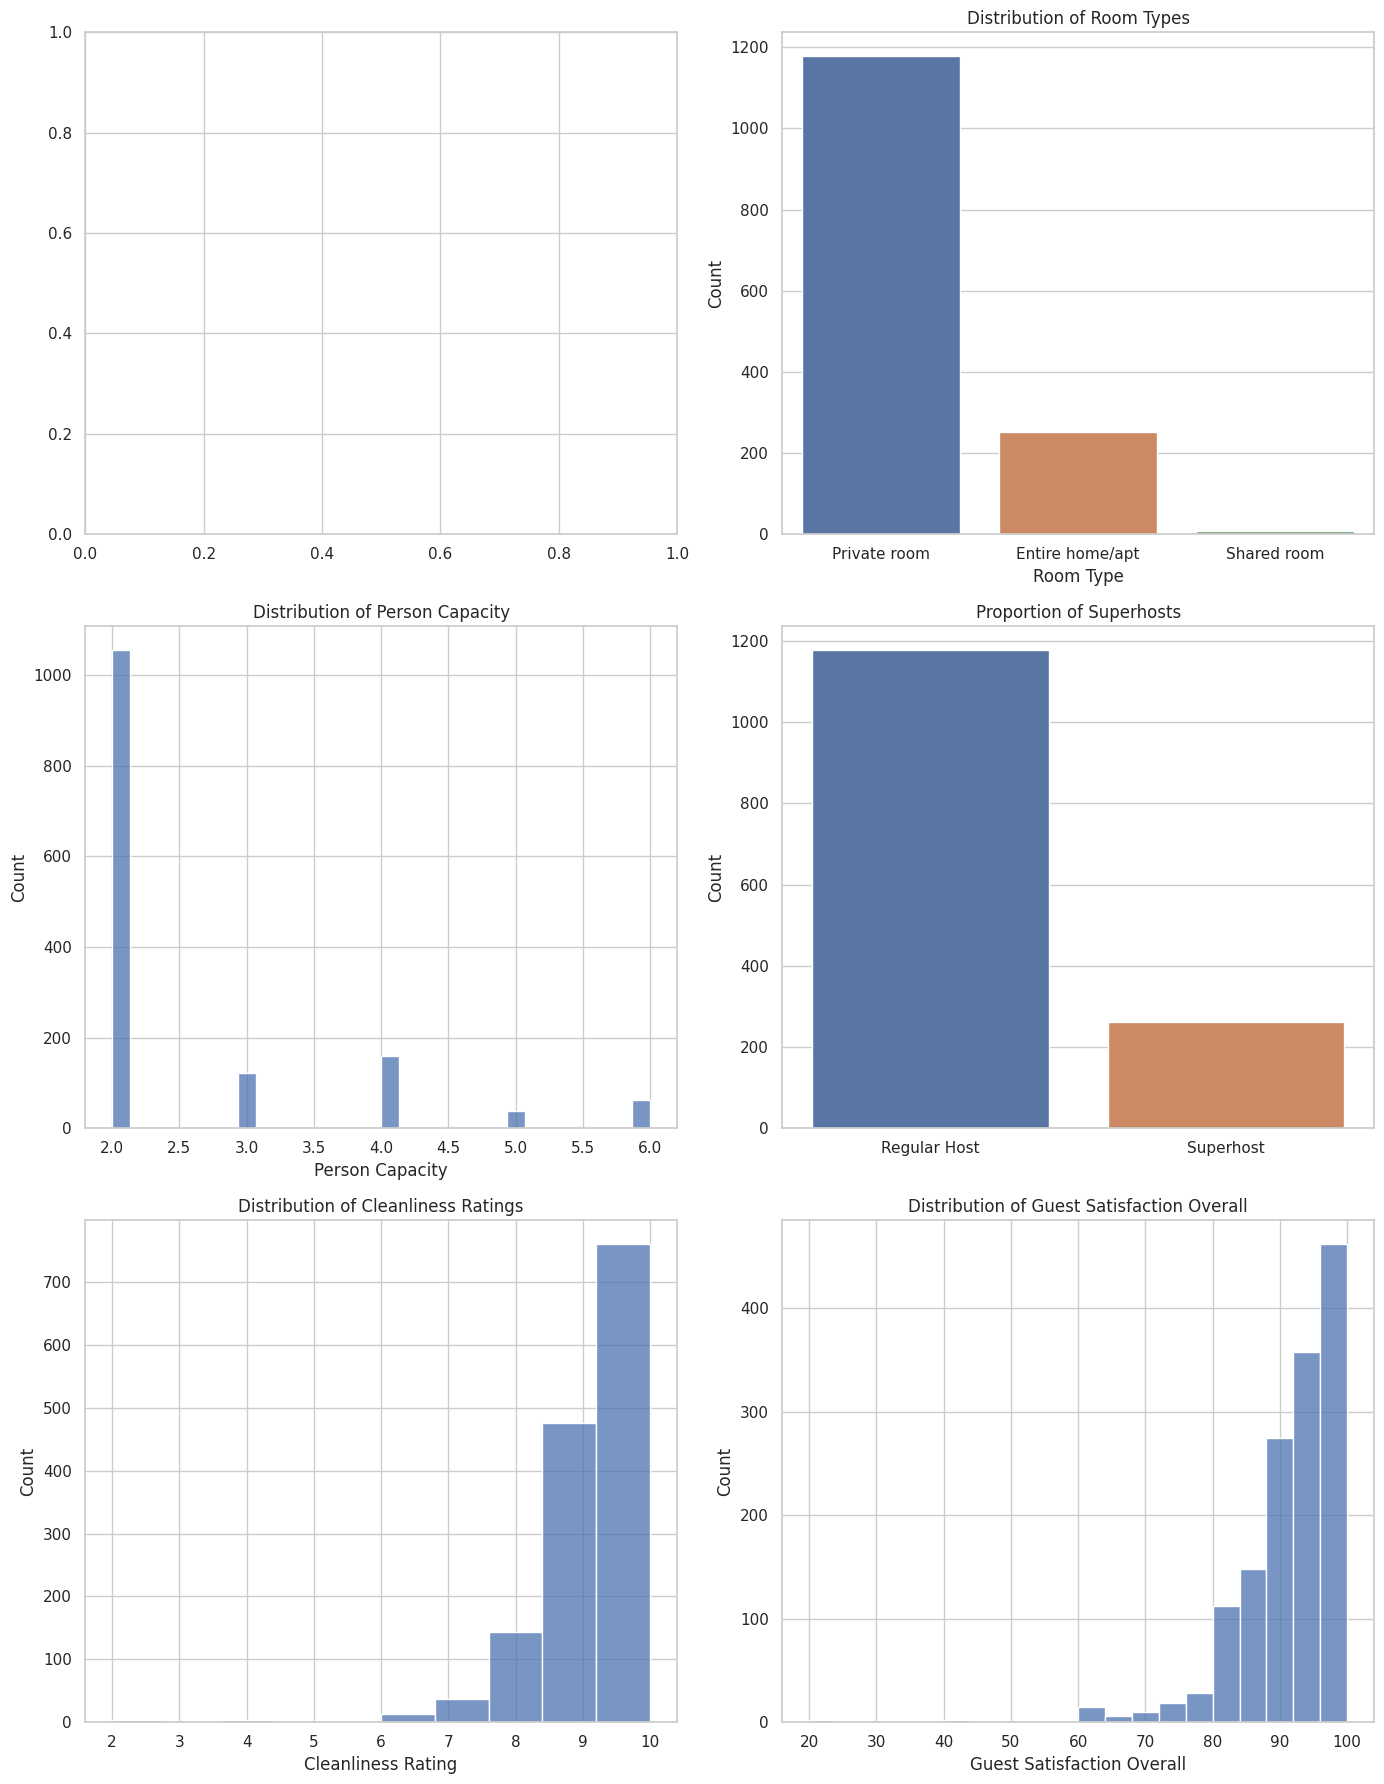

In [25]:
# Setting the aesthetics for the plots
sns.set(style="whitegrid")

# Create a figure for multiple subplots
fig, axes = plt.subplots(3, 2, figsize=(14, 18))

# # Plotting the number of listings per city
# sns.countplot(data=df, y='city', ax=axes[0, 0], order=data['city'].value_counts().index)
# axes[0, 0].set_title('Number of Listings per City')
# axes[0, 0].set_xlabel('')
# axes[0, 0].set_ylabel('City')

# Plotting the distribution of room types
sns.countplot(data=df, x='room_type', ax=axes[0, 1], order=df['room_type'].value_counts().index)
axes[0, 1].set_title('Distribution of Room Types')
axes[0, 1].set_xlabel('Room Type')
axes[0, 1].set_ylabel('Count')

# Plotting the distribution of person capacity
sns.histplot(data=df, x='person_capacity', bins=30, ax=axes[1, 0], kde=False)
axes[1, 0].set_title('Distribution of Person Capacity')
axes[1, 0].set_xlabel('Person Capacity')
axes[1, 0].set_ylabel('Count')

# Plotting the proportion of superhosts
df['superhost_label'] = df['host_is_superhost'].map({True: 'Superhost', False: 'Regular Host'})
sns.countplot(data=df, x='superhost_label', ax=axes[1, 1])
axes[1, 1].set_title('Proportion of Superhosts')
axes[1, 1].set_xlabel('')
axes[1, 1].set_ylabel('Count')

# Plotting the distribution of cleanliness ratings
sns.histplot(data=df, x='cleanliness_rating', bins=10, ax=axes[2, 0], kde=False)
axes[2, 0].set_title('Distribution of Cleanliness Ratings')
axes[2, 0].set_xlabel('Cleanliness Rating')
axes[2, 0].set_ylabel('Count')

# Plotting the distribution of guest satisfaction overall
sns.histplot(data=df, x='guest_satisfaction_overall', bins=20, ax=axes[2, 1], kde=False)
axes[2, 1].set_title('Distribution of Guest Satisfaction Overall')
axes[2, 1].set_xlabel('Guest Satisfaction Overall')
axes[2, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

## Feature Selection/Extraction:

In [26]:
# Encode categorical features
label_encoders = {}
# for column in ['room_type', 'city']:
#     le = LabelEncoder()
#     df_copy[column] = le.fit_transform(df_copy[column])
#     label_encoders[column] = le

for column in ['room_type']:
    le = LabelEncoder()
    df_copy[column] = le.fit_transform(df_copy[column])
    label_encoders[column] = le

# Convert boolean columns to int (True/False to 1/0)
bool_columns = ['room_shared', 'room_private', 'host_is_superhost']
for column in bool_columns:
    df_copy[column] = df_copy[column].astype(int)

# Show the updated dataframe and check types again
df_copy.head(), df_copy.dtypes

(      realSum  room_type  room_shared  room_private  person_capacity  \
 1  297.670305          1            0             1              2.0   
 2  190.844136          1            0             1              2.0   
 3  260.199688          1            0             1              2.0   
 4  208.532129          1            0             1              2.0   
 5  194.335187          1            0             1              2.0   
 
    host_is_superhost  multi  biz  cleanliness_rating  \
 1                  0      0    1                10.0   
 2                  0      0    0                10.0   
 3                  0      0    1                 9.0   
 4                  0      1    0                 8.0   
 5                  0      1    0                 9.0   
 
    guest_satisfaction_overall  bedrooms      dist  metro_dist  attr_index  \
 1                       100.0         1  1.457153    0.134674  356.968183   
 2                       100.0         1  1.802640    0.3512

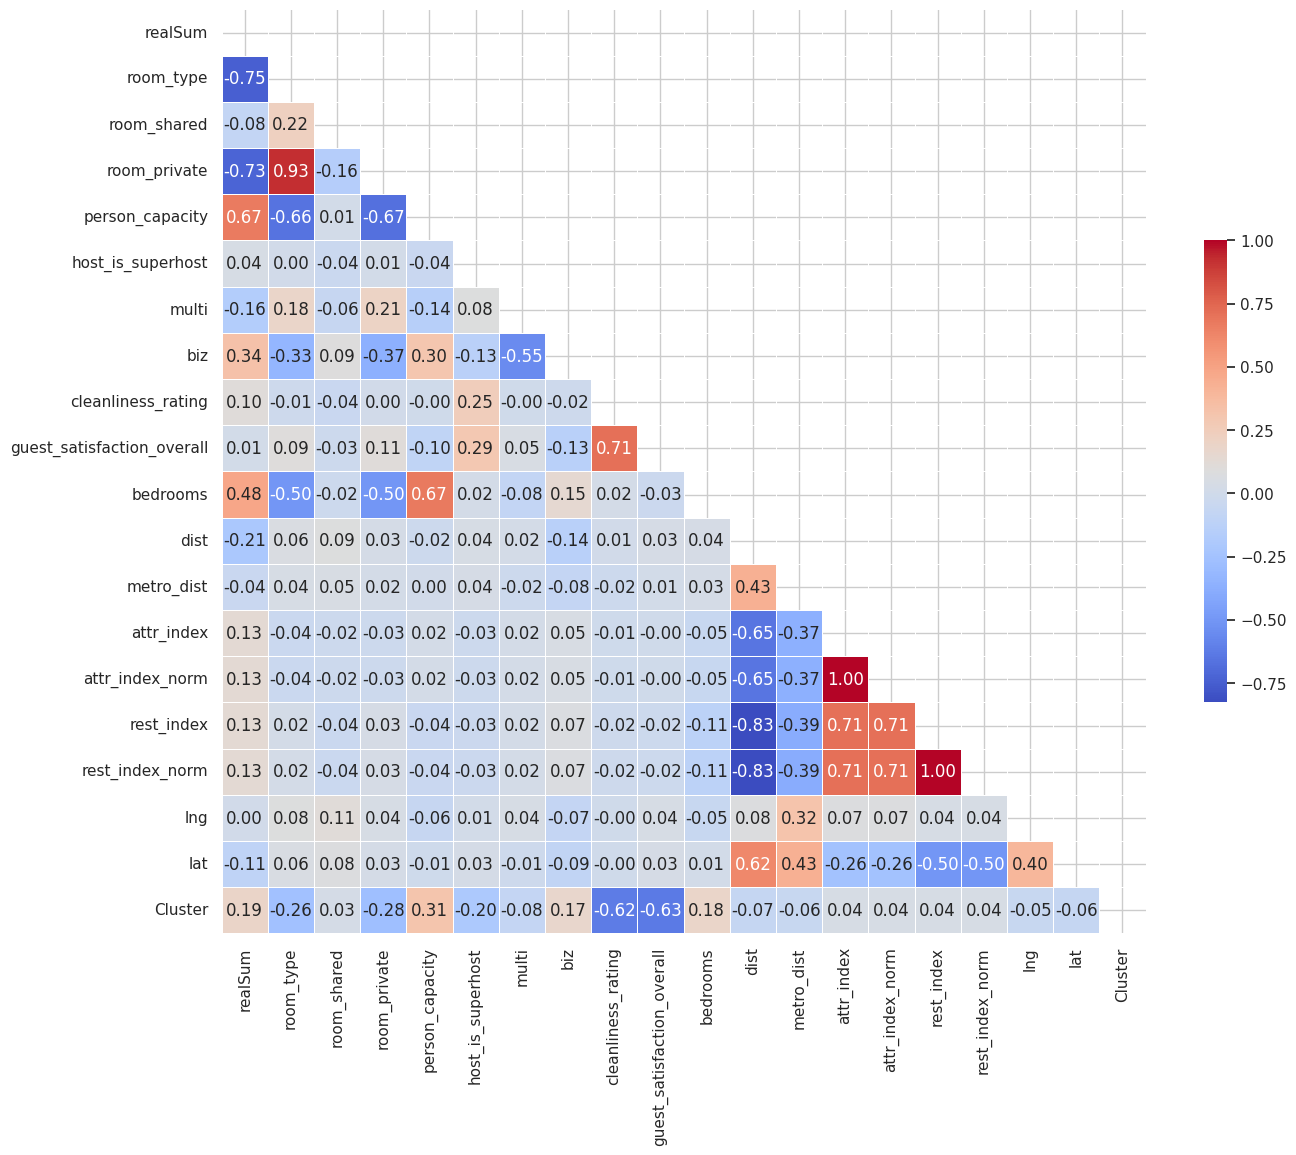

In [27]:
# Compute the correlation matrix
corr_matrix = df_copy.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(15, 12))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Show plot
plt.show()

In [28]:
# Calculate the correlation matrix
correlation_matrix = df_copy.corr()

# Filter out columns where the correlation with 'realSum' is between -0.1 and 0.1
low_correlation_columns = correlation_matrix[(correlation_matrix['realSum'] > -0.1) & (correlation_matrix['realSum'] < 0.1)].index

# Print the columns with low correlation
print(low_correlation_columns)

# Remove these columns from the dataset
df_reduced = df.drop(columns=low_correlation_columns)
print(df_reduced.head())

Index(['room_shared', 'host_is_superhost', 'guest_satisfaction_overall',
       'metro_dist', 'lng'],
      dtype='object')
      realSum     room_type  room_private  person_capacity  multi  biz  \
1  297.670305  Private room          True              2.0      0    1   
2  190.844136  Private room          True              2.0      0    0   
3  260.199688  Private room          True              2.0      0    1   
4  208.532129  Private room          True              2.0      1    0   
5  194.335187  Private room          True              2.0      1    0   

   cleanliness_rating  bedrooms      dist  attr_index  attr_index_norm  \
1                10.0         1  1.457153  356.968183        12.166051   
2                10.0         1  1.802640  356.234898        12.141060   
3                 9.0         1  1.274725  544.935022        18.572264   
4                 8.0         1  2.074769  342.946262        11.688162   
5                 9.0         1  1.011674  530.522085        

In [29]:
df.dtypes

realSum                       float64
room_type                      object
room_shared                      bool
room_private                     bool
person_capacity               float64
host_is_superhost                bool
multi                           int64
biz                             int64
cleanliness_rating            float64
guest_satisfaction_overall    float64
bedrooms                        int64
dist                          float64
metro_dist                    float64
attr_index                    float64
attr_index_norm               float64
rest_index                    float64
rest_index_norm               float64
lng                           float64
lat                           float64
superhost_label                object
dtype: object

# Prepare Training Data

In [30]:
# There is only numeric data left, so we only need to StandardScaler Numeric data
numeric_cols = df_reduced.select_dtypes(include=['int64', 'float64']).columns.tolist()
object_cols = df_reduced.select_dtypes(include=['object']).columns.tolist()

# Remove the 'realSum' column from the list
numeric_cols.remove('realSum')

scaler = StandardScaler()
scaled_numeric_data = scaler.fit_transform(df_reduced[numeric_cols])
df_transformed_numeric = pd.DataFrame(scaled_numeric_data, columns=numeric_cols)

# One-hot encoding the categorical data
df_encoded = pd.get_dummies(df_reduced[object_cols])

# Concatenate the scaled numeric data and encoded categorical data
df_transformed = pd.concat([df_transformed_numeric, df_encoded], axis=1)

df_transformed = df_transformed.to_numpy()
df_transformed

array([[-0.5232178024747288, -0.8150778195067339, 1.4769617223217195,
        ..., nan, nan, nan],
       [-0.5232178024747288, -0.8150778195067339, -0.6770656171292263,
        ..., False, True, False],
       [-0.5232178024747288, -0.8150778195067339, 1.4769617223217195,
        ..., False, True, False],
       ...,
       [nan, nan, nan, ..., False, True, False],
       [nan, nan, nan, ..., False, True, False],
       [nan, nan, nan, ..., False, False, True]], dtype=object)

In [31]:
# Data preparation and column selection
numeric_cols = df_reduced.select_dtypes(include=['int64', 'float64']).columns.tolist()
object_cols = df_reduced.select_dtypes(include=['object']).columns.tolist()

# Remove 'realSum' column
if 'realSum' in numeric_cols:
    numeric_cols.remove('realSum')

# Create a ColumnTransformer to handle both numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(), object_cols)
    ])

# Apply the ColumnTransformer
df_transformed = preprocessor.fit_transform(df_reduced)

# Get the names of the one-hot encoded columns
columns_transformed = numeric_cols + list(preprocessor.named_transformers_['cat'].get_feature_names_out())
df_transformed = pd.DataFrame(df_transformed, columns=columns_transformed)

# Convert to NumPy array
df_transformed_array = df_transformed.to_numpy()

df_transformed_array

array([[-0.5232178 , -0.81507782,  1.47696172, ...,  0.        ,
         1.        ,  0.        ],
       [-0.5232178 , -0.81507782, -0.67706562, ...,  0.        ,
         1.        ,  0.        ],
       [-0.5232178 , -0.81507782,  1.47696172, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.5232178 ,  1.22687672, -0.67706562, ...,  0.        ,
         1.        ,  0.        ],
       [-0.5232178 ,  1.22687672, -0.67706562, ...,  0.        ,
         1.        ,  0.        ],
       [-0.5232178 ,  1.22687672, -0.67706562, ...,  0.        ,
         0.        ,  1.        ]])

In [32]:
y = df_reduced['realSum'].values

# Split Test Data
X_train_val, X_test, y_train_val, y_test = train_test_split(df_transformed_array, y, test_size=0.2, random_state=42)

# Split Validation Data
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42) 

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Linear Regression Model

## Model Define

In [33]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [34]:
class LinearRegression(nn.Module):
    def __init__(self, n_features):
        super(LinearRegression, self).__init__()
        # Defining a linear layer with n_features input features and 1 output feature
        self.linear = nn.Linear(n_features, 1)

    def forward(self, x):
        # Forward pass through the linear layer
        return self.linear(x)

In [35]:
model = LinearRegression(X_train.shape[1]).to(device)
print(model)

LinearRegression(
  (linear): Linear(in_features=16, out_features=1, bias=True)
)


In [36]:
loss_function = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.01) 

In [37]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0.0001):  
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.reset()

    def reset(self):
        self.best_score = None
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score - self.delta:  
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered")
        else:
            self.best_score = score
            self.epochs_no_improve = 0

## Model Training

In [38]:
def cross_validate_model(X, y, n_splits=5, epochs=50, batch_size=64, epsilon=0.1, lr=0.001, weight_decay=0.001):
    all_val_losses = []
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    best_model = None
    lowest_val_loss = np.inf

    for fold, (train_index, val_index) in enumerate(kf.split(X_train_val), 1):
        print(f"Starting fold {fold}")
        X_train, X_val = X_train_val[train_index], X_train_val[val_index]
        y_train, y_val = y_train_val[train_index], y_train_val[val_index]

        train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
        val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = LinearRegression(n_features=X_train.shape[1]).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.01) 
        early_stopping = EarlyStopping(patience=10, verbose=True)
        

        for epoch in range(epochs):
            model.train()
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = loss_function(output, target)
                loss.backward()
                optimizer.step()

            val_loss = 0
            model.eval()
            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    val_loss += loss_function(output, target).item()
            val_loss /= len(val_loader)

            if epoch % 100 == 0: 
                print(f'Fold {fold}, Epoch {epoch+1}, Validation MAE Loss: {val_loss}')

            if val_loss < lowest_val_loss:
                lowest_val_loss = val_loss
                best_model = model.state_dict()  # Save the best model
                torch.save(best_model, 'LinearRegression_best_model.pth')  # Save model to disk
            early_stopping(val_loss)
            if early_stopping.early_stop:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
                
        all_val_losses.append(val_loss)
        
    avg_val_loss = np.mean(all_val_losses)
    print(f'Average Validation Loss: {avg_val_loss}')
    return avg_val_loss

In [39]:
cross_validate_model(df_transformed_array, y, n_splits=5, epochs=100000, batch_size=64, lr=0.01, epsilon=0.0001)

Starting fold 1
Fold 1, Epoch 1, Validation MAE Loss: 68041.349609375


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([38])) that is different to the input size (torch.Size([38, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Fold 1, Epoch 101, Validation MAE Loss: 49918.794921875
Fold 1, Epoch 201, Validation MAE Loss: 36124.9140625
Fold 1, Epoch 301, Validation MAE Loss: 25973.71533203125
Fold 1, Epoch 401, Validation MAE Loss: 18969.55859375
Fold 1, Epoch 501, Validation MAE Loss: 14766.995849609375
Fold 1, Epoch 601, Validation MAE Loss: 12826.294677734375
Fold 1, Epoch 701, Validation MAE Loss: 12289.91064453125
Fold 1, Epoch 801, Validation MAE Loss: 12226.006591796875
Early stopping triggered
Early stopping triggered at epoch 805
Starting fold 2
Fold 2, Epoch 1, Validation MAE Loss: 67893.357421875
Fold 2, Epoch 101, Validation MAE Loss: 49722.990234375
Fold 2, Epoch 201, Validation MAE Loss: 35958.458984375
Fold 2, Epoch 301, Validation MAE Loss: 25902.82861328125
Fold 2, Epoch 401, Validation MAE Loss: 19066.094970703125
Fold 2, Epoch 501, Validation MAE Loss: 15021.201904296875
Fold 2, Epoch 601, Validation MAE Loss: 13183.8271484375
Fold 2, Epoch 701, Validation MAE Loss: 12717.720703125
Early st

12591.915576171876

In [40]:
def load_best_model(input_features):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LinearRegression(n_features=input_features).to(device)
    model.load_state_dict(torch.load('/kaggle/working/LinearRegression_best_model.pth', map_location=device))
    return model, device

best_model, device = load_best_model(df_transformed.shape[1])

In [41]:
def evaluate_model(model, test_loader, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_function(output, target).item()  # 假设 epsilon=0.1
    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss}')

evaluate_model(best_model, test_loader, device)

Test Loss: 14110.7400390625


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [42]:
def calculate_metrics(model, test_loader, device):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            actuals.extend(target.view_as(output).detach().cpu().numpy())
            predictions.extend(output.detach().cpu().numpy())

    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R²: {r2}')

calculate_metrics(best_model, test_loader, device)

MSE: 13892.455078125, RMSE: 117.86625671386719, MAE: 90.79340362548828, R²: 0.002495175619448897


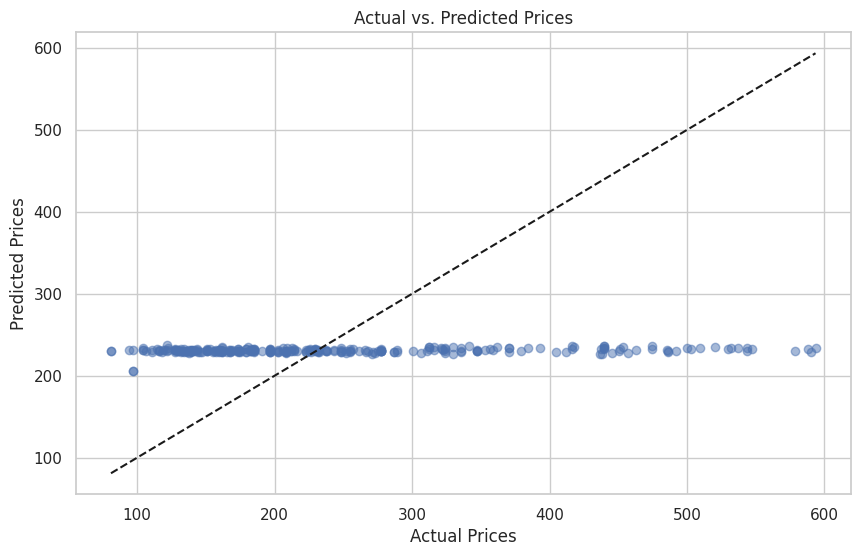

In [43]:
def plot_predictions(model, test_loader, device):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            actuals.extend(target.view_as(output).detach().cpu().numpy())
            predictions.extend(output.detach().cpu().numpy())
    
    plt.figure(figsize=(10, 6))
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title('Actual vs. Predicted Prices')
    plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'k--')
    plt.show()

plot_predictions(best_model, test_loader, device)

# Random Forest Model

## Model Define

In [44]:
from sklearn.ensemble import RandomForestRegressor

class RandomForest:
    def __init__(self, n_estimators=100, max_depth=None, random_state=42):
        """Initialize the random forest model."""
        self.model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)

    def fit(self, X, y):
        """Fit the model to the data."""
        self.model.fit(X, y)

    def predict(self, X):
        """Make predictions using the trained model."""
        return self.model.predict(X)

In [45]:
model = RandomForest(n_estimators=100, max_depth=None, random_state=42)
print(model)

In [46]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0.0001):  
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.reset()

    def reset(self):
        self.best_score = None
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score - self.delta:  
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered")
        else:
            self.best_score = score
            self.epochs_no_improve = 0

## Model Training

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
import joblib

def cross_validate_model(X, y, n_splits=5):
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    val_losses = []
    best_model = None
    lowest_val_loss = np.inf

    for train_index, val_index in kf.split(X_train_val):
        X_train, X_val = X_train_val[train_index], X_train_val[val_index]
        y_train, y_val = y_train_val[train_index], y_train_val[val_index]

        model = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_val)
        val_loss = mean_squared_error(y_val, y_pred)
        val_losses.append(val_loss)
        
        # Update the best model if current model is better
        if val_loss < lowest_val_loss:
            lowest_val_loss = val_loss
            best_model = model
        
        print(f'Validation MSE: {val_loss}')

    avg_val_loss = np.mean(val_losses)
    print(f'Average Validation Loss: {avg_val_loss}')
    
    # Save the best model
    joblib.dump(best_model, 'RandomForest_best_model.pkl')
    
    return avg_val_loss

# Split Test Data
X_train_val, X_test, y_train_val, y_test = train_test_split(df_transformed_array, y, test_size=0.2, random_state=42)

avg_loss = cross_validate_model(X_train_val, y_train_val)

Validation MSE: 3136.285229295997
Validation MSE: 4261.300366645712
Validation MSE: 4264.736721368541
Validation MSE: 3460.2585275773904
Validation MSE: 4774.996061792766
Average Validation Loss: 3979.515381336081


In [48]:
# Load the best model for further testing
best_model = joblib.load('/kaggle/working/RandomForest_best_model.pkl')

In [49]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_test_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_test_pred)

rmse = np.sqrt(mse)

mae = mean_absolute_error(y_test, y_test_pred)

r2 = r2_score(y_test, y_test_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

MSE: 4573.568184429262
RMSE: 67.62816117882596
MAE: 51.044818310176005
R²: 0.6716090446860097


# SVR Model

## Model Define

In [50]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [51]:
class SVR(nn.Module):
    def __init__(self, n_features):
        super(SVR, self).__init__()
        self.linear = nn.Linear(n_features, 1)

    def forward(self, x):
        return self.linear(x)

In [52]:
def epsilon_insensitive_loss(outputs, targets, epsilon=0.1):
    errors = torch.abs(targets - outputs.squeeze())

    loss = torch.mean(torch.max(errors - epsilon, torch.zeros_like(errors)))
    return loss

In [53]:
model = SVR(X_train.shape[1]).to(device)
print(model)

SVR(
  (linear): Linear(in_features=16, out_features=1, bias=True)
)


In [54]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)

In [55]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0.0001):  
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.reset()

    def reset(self):
        self.best_score = None
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score - self.delta:  
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print("Early stopping triggered")
        else:
            self.best_score = score
            self.epochs_no_improve = 0

## Model Training

In [56]:
def cross_validate_model(X, y, n_splits=5, epochs=50, batch_size=64, epsilon=0.1, lr=0.001, weight_decay=0.001):
    all_val_losses = []
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    best_model = None
    lowest_val_loss = np.inf

    for fold, (train_index, val_index) in enumerate(kf.split(X_train_val), 1):
        print(f"Starting fold {fold}")
        X_train, X_val = X_train_val[train_index], X_train_val[val_index]
        y_train, y_val = y_train_val[train_index], y_train_val[val_index]

        train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
        val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = SVR(n_features=X_train.shape[1]).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
        early_stopping = EarlyStopping(patience=10, verbose=True)

        for epoch in range(epochs):
            model.train()
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = epsilon_insensitive_loss(output, target, epsilon)
                loss.backward()
                optimizer.step()

            val_loss = 0
            model.eval()
            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    val_loss += epsilon_insensitive_loss(output, target, epsilon).item()
            val_loss /= len(val_loader)

            if epoch % 100 == 0: 
                print(f'Fold {fold}, Epoch {epoch+1}, Validation MAE Loss: {val_loss}')

            if val_loss < lowest_val_loss:
                lowest_val_loss = val_loss
                best_model = model.state_dict()  # Save the best model
                torch.save(best_model, 'SVR_best_model.pth')  # Save model to disk

            early_stopping(val_loss)
            if early_stopping.early_stop:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
                
        all_val_losses.append(val_loss)
        
    avg_val_loss = np.mean(all_val_losses)
    print(f'Average Validation Loss: {avg_val_loss}')
    return avg_val_loss

In [57]:
cross_validate_model(df_transformed_array, y, n_splits=5, epochs=100000, batch_size=64, lr=0.01, epsilon=0.0001)

Starting fold 1
Fold 1, Epoch 1, Validation MAE Loss: 236.49836349487305
Fold 1, Epoch 101, Validation MAE Loss: 200.84447860717773
Fold 1, Epoch 201, Validation MAE Loss: 165.84331512451172
Fold 1, Epoch 301, Validation MAE Loss: 133.78678512573242
Fold 1, Epoch 401, Validation MAE Loss: 110.84756851196289
Fold 1, Epoch 501, Validation MAE Loss: 97.89020538330078
Fold 1, Epoch 601, Validation MAE Loss: 90.66338348388672
Fold 1, Epoch 701, Validation MAE Loss: 85.24600791931152
Fold 1, Epoch 801, Validation MAE Loss: 81.05490303039551
Fold 1, Epoch 901, Validation MAE Loss: 77.7631721496582
Fold 1, Epoch 1001, Validation MAE Loss: 75.08674049377441
Fold 1, Epoch 1101, Validation MAE Loss: 72.72221374511719
Fold 1, Epoch 1201, Validation MAE Loss: 70.67677116394043
Fold 1, Epoch 1301, Validation MAE Loss: 68.9982500076294
Fold 1, Epoch 1401, Validation MAE Loss: 67.53293895721436
Fold 1, Epoch 1501, Validation MAE Loss: 66.46588516235352
Fold 1, Epoch 1601, Validation MAE Loss: 65.53050

52.71316642761231

In [58]:
# param_grid = {
#     'lr': [0.01, 0.001, 0.0001],
#     'weight_decay': [0.01, 0.001, 0.0001],
#     'batch_size': [32, 64, 128]
# }

# best_model_params = None
# lowest_val_loss = np.inf
# grid = list(ParameterGrid(param_grid))

# for params in grid:
#     print("Testing parameters:", params)
#     current_val_loss = cross_validate_model(
#         X=df_transformed_array,
#         y=y,
#         n_splits=5,
#         epochs=300,
#         batch_size=params['batch_size'],
#         epsilon=0.1,
#         lr=params['lr'],
#         weight_decay=params['weight_decay']
#     )
    
#     if current_val_loss < lowest_val_loss:
#         lowest_val_loss = current_val_loss
#         best_model_params = copy.deepcopy(params)

# print(f"Best Validation Loss: {lowest_val_loss}")
# print("Best parameters:", best_model_params)

## Test Results

In [59]:
def load_best_model(input_features):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SVR(n_features=input_features).to(device)
    model.load_state_dict(torch.load('SVR_best_model.pth', map_location=device))
    return model, device

best_model, device = load_best_model(df_transformed.shape[1])

In [60]:
def evaluate_model(model, test_loader, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += epsilon_insensitive_loss(output, target, 0.1).item()  # 假设 epsilon=0.1
    test_loss /= len(test_loader)
    print(f'Test Loss: {test_loss}')

evaluate_model(best_model, test_loader, device)

Test Loss: 58.72527847290039


In [61]:
def calculate_metrics(model, test_loader, device):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            actuals.extend(target.view_as(output).detach().cpu().numpy())
            predictions.extend(output.detach().cpu().numpy())

    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R²: {r2}')

calculate_metrics(best_model, test_loader, device)

MSE: 6926.9990234375, RMSE: 83.22859191894531, MAE: 60.37639617919922, R²: 0.5026282153136883


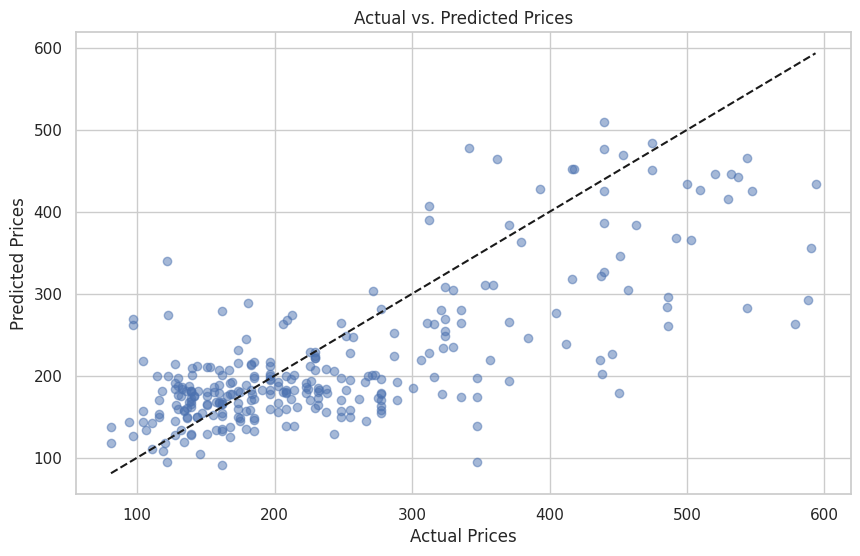

In [62]:
def plot_predictions(model, test_loader, device):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            actuals.extend(target.view_as(output).detach().cpu().numpy())
            predictions.extend(output.detach().cpu().numpy())
    
    plt.figure(figsize=(10, 6))
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title('Actual vs. Predicted Prices')
    plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'k--')
    plt.show()

plot_predictions(best_model, test_loader, device)

# *MLP* Model

## Model Define

In [63]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.relu3(self.fc3(x))
        x = self.output(x)
        return x

In [64]:
# class MLP(nn.Module):
#     def __init__(self, input_dim):
#         super(MLP, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 256)
#         self.relu1 = nn.ReLU()
#         self.fc2 = nn.Linear(256, 128)
#         self.relu2 = nn.ReLU()
#         self.fc3 = nn.Linear(128, 64)
#         self.relu3 = nn.ReLU()
#         self.fc4 = nn.Linear(64, 32) 
#         self.relu4 = nn.ReLU()
#         self.output = nn.Linear(32, 1)
#         self.dropout = nn.Dropout(0.5) 

#     def forward(self, x):
#         x = self.relu1(self.fc1(x))
#         x = self.dropout(x) 
#         x = self.relu2(self.fc2(x))
#         x = self.dropout(x)
#         x = self.relu3(self.fc3(x))
#         x = self.dropout(x)
#         x = self.relu4(self.fc4(x))
#         x = self.output(x)
#         return x

In [65]:
model = MLP(input_dim=X_train.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Model Training

In [66]:
def cross_validate_model(X, y, n_splits=5, epochs=50, batch_size=64, epsilon=0.1, lr=0.001, weight_decay=0.01):
    all_val_losses = []
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    best_model = None
    lowest_val_loss = np.inf

    for fold, (train_index, val_index) in enumerate(kf.split(X_train_val), 1):
        print(f"Starting fold {fold}")
        X_train, X_val = X_train_val[train_index], X_train_val[val_index]
        y_train, y_val = y_train_val[train_index], y_train_val[val_index]

        train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
        val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = MLP(input_dim=X_train.shape[1]).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
        early_stopping = EarlyStopping(patience=10, verbose=True)

        for epoch in range(epochs):
            model.train()
            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                loss = epsilon_insensitive_loss(output, target, epsilon)
                loss.backward()
                optimizer.step()

            val_loss = 0
            model.eval()
            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    val_loss += epsilon_insensitive_loss(output, target, epsilon).item()
            val_loss /= len(val_loader)
            
            if epoch % 100 ==0: 
                print(f'Fold {fold}, Epoch {epoch+1}, Validation MAE Loss: {val_loss}')
            
            if val_loss < lowest_val_loss:
                lowest_val_loss = val_loss
                best_model = model.state_dict()  # Save the best model
                torch.save(best_model, 'MLP_best_model.pth')  # Save model to disk

            early_stopping(val_loss)
            if early_stopping.early_stop:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break
                
        all_val_losses.append(val_loss)
        
    avg_val_loss = np.mean(all_val_losses)
    print(f'Average Validation Loss: {avg_val_loss}')
    return avg_val_loss

In [67]:
cross_validate_model(df_transformed_array, y, n_splits=5, epochs=10000, batch_size=64, lr=0.001, epsilon=0.01)

Starting fold 1
Fold 1, Epoch 1, Validation MAE Loss: 236.91064453125
Fold 1, Epoch 101, Validation MAE Loss: 52.24570560455322
Early stopping triggered
Early stopping triggered at epoch 140
Starting fold 2
Fold 2, Epoch 1, Validation MAE Loss: 235.02640533447266
Fold 2, Epoch 101, Validation MAE Loss: 47.17554950714111
Early stopping triggered
Early stopping triggered at epoch 116
Starting fold 3
Fold 3, Epoch 1, Validation MAE Loss: 236.7376365661621
Fold 3, Epoch 101, Validation MAE Loss: 49.39042854309082
Early stopping triggered
Early stopping triggered at epoch 136
Starting fold 4
Fold 4, Epoch 1, Validation MAE Loss: 231.09238052368164
Fold 4, Epoch 101, Validation MAE Loss: 43.87228584289551
Early stopping triggered
Early stopping triggered at epoch 105
Starting fold 5
Fold 5, Epoch 1, Validation MAE Loss: 240.68495178222656
Fold 5, Epoch 101, Validation MAE Loss: 50.305426597595215
Early stopping triggered
Early stopping triggered at epoch 148
Average Validation Loss: 47.80972

47.80972023010254

In [68]:
# param_grid = {
#     'lr': [0.01, 0.001, 0.0001],
#     'weight_decay': [0.01, 0.001, 0.0001],
#     'batch_size': [32, 64, 128]
# }

# best_model_params = None
# lowest_val_loss = np.inf
# grid = list(ParameterGrid(param_grid))

# for params in grid:
#     print("Testing parameters:", params)
#     current_val_loss = cross_validate_model(
#         X=df_transformed_array,
#         y=y,
#         n_splits=5,
#         epochs=100000,
#         batch_size=params['batch_size'],
#         epsilon=0.1,
#         lr=params['lr'],
#         weight_decay=params['weight_decay']
#     )
    
#     if current_val_loss < lowest_val_loss:
#         lowest_val_loss = current_val_loss
#         best_model_params = copy.deepcopy(params)

# print(f"Best Validation Loss: {lowest_val_loss}")
# print("Best parameters:", best_model_params)

## Test Result

In [69]:
def load_best_model(input_features):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MLP(input_dim=X_train.shape[1]).to(device)
    model.load_state_dict(torch.load('MLP_best_model.pth', map_location=device))
    return model, device

In [70]:
best_model, device = load_best_model(df_transformed.shape[1])

In [71]:
evaluate_model(best_model, test_loader, device)

Test Loss: 54.31322174072265


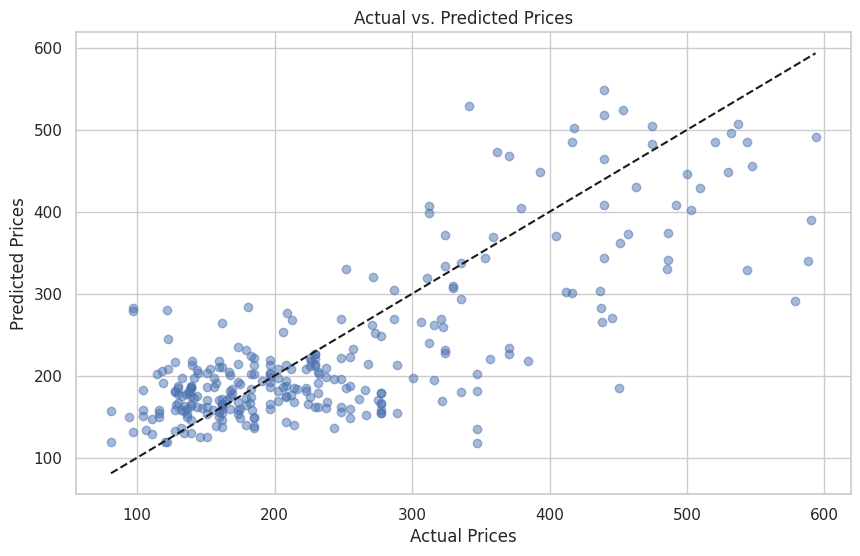

In [72]:
plot_predictions(best_model, test_loader, device)